In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sklearn

In [2]:
def to_hours(time):
    return (time // 3600) + 6

def clean_sales_data():
    df = pd.read_csv("../data/master_data/sales_data.csv")
    sales_df = df[['token_id', 'sold_at', 'price']]
    sales_df = sales_df.rename(columns={'token_id': 'horse_id', 'sold_at': 'time_sold'}).sort_values('horse_id').reset_index(drop=True)
    sales_df['timestamp'] = sales_df['time_sold'].apply(to_hours)

    return sales_df

## Olivers merging code

In [3]:
filenames = ['sales_and_stats_harper.csv', 'sales_and_stats_jason.csv']

meta_data_races = pd.read_csv("../sales_and_stats_oliver.csv")

for file in filenames:
    new_df = pd.read_csv(f'../{file}')
    meta_data_races = pd.concat([meta_data_races,new_df], axis = 0)

meta_data_attributes = pd.read_csv("../data/master_data/backup_meta_db.csv")

# print(f"columns of meta_data_races = \n {meta_data_races.columns}")
# print(f"columns of meta_data_attributes = \n {meta_data_attributes.columns}")

merged = meta_data_attributes.copy()

meta_merged = merged.merge(meta_data_races, on = "horse_id", how = "outer").fillna(0)
meta_merged = meta_merged.drop(columns=['Unnamed: 0_y', 'Unnamed: 0_x', ])
meta_merged.columns

Index(['currency', 'price', 'sold_at', 'horse_id', 'genotype', 'bloodline',
       'breed_type', 'color', 'birthday', 'super_coat', 'mother', 'father',
       'horse_type', 'free_win_rate', 'paid_win_rate', 'place', 'total_paid',
       'win_rate', 'overall.first', 'overall.races', 'overall.second',
       'overall.third'],
      dtype='object')

In [4]:
# replace complex token names with easier to understand names and drop rows paid for with zed_tokens

meta_merged.replace(to_replace='0x5ec03c1f7fa7ff05ec476d19e34a22eddb48acdc', value='zed_token', inplace=True)
meta_merged.replace(to_replace='0x7ceb23fd6bc0add59e62ac25578270cff1b9f619', value='eth', inplace=True)

meta_merged = meta_merged[meta_merged['currency'] != 'zed_token']
meta_merged.currency.value_counts()

#drop currency column now that price is just eth

meta_merged = meta_merged.drop(columns=['currency'])


### convert sales times to match eth price times

In [5]:
meta_sales = meta_merged.rename(columns={'sold_at': 'time_sold'}).sort_values('horse_id').reset_index(drop=True)
meta_sales['timestamp'] = meta_sales['time_sold'].apply(to_hours)

In [6]:
#sales_data = clean_sales_data()

In [7]:
eth_prices = pd.read_csv('../data/master_data/eth_price_history.csv')
eth_prices.tail()

,Unnamed: 0,timestamp,eth_price
9091,9091,464923,1533.01
9092,9092,464924,1529.65
9093,9093,464925,1535.38
9094,9094,464926,1538.76
9095,9095,464927,1550.97


In [8]:
eth_merge = pd.merge(meta_sales, eth_prices, left_on='timestamp', right_on='timestamp', how='left')
eth_merge['converted_price'] = eth_merge['price'] * eth_merge['eth_price']
clean_market_data = eth_merge.drop(columns=['Unnamed: 0', 'price', 'timestamp','eth_price'])


def to_day(unix_time):
    return datetime.date.fromtimestamp(unix_time)

clean_market_data['day_sold'] = clean_market_data['time_sold'].apply(to_day)
clean_market_data

,time_sold,horse_id,genotype,bloodline,breed_type,color,birthday,super_coat,mother,father,...,paid_win_rate,place,total_paid,win_rate,overall.first,overall.races,overall.second,overall.third,converted_price,day_sold
0,1650124789,27,Z1,Nakamoto,genesis,Absolute Zero,2019-01-31T03:48:43,False,0.0,0.0,...,8.20,39.37,4.786438,12.41,226.0,1821.0,254.0,237.0,60665.00000,2022-04-16
1,1657313128,68,Z1,Nakamoto,genesis,Slate Gray,2019-02-07T09:20:41,False,0.0,0.0,...,0.00,57.89,0.039840,13.16,5.0,38.0,5.0,12.0,13934.20500,2022-07-08
2,1657313072,75,Z1,Nakamoto,genesis,Slate Gray,2019-02-07T11:15:31,False,0.0,0.0,...,0.00,55.00,0.002400,20.00,4.0,20.0,5.0,2.0,9693.36000,2022-07-08
3,1657313100,89,Z1,Nakamoto,genesis,Slate Gray,2019-02-15T19:45:15,False,0.0,0.0,...,0.00,56.52,0.009720,21.74,5.0,23.0,3.0,5.0,9693.36000,2022-07-08
4,1663112422,92,Z1,Nakamoto,genesis,Champagne Papi,2019-02-16T13:09:35,False,0.0,0.0,...,13.04,38.04,0.160059,10.14,28.0,276.0,37.0,40.0,10943.77500,2022-09-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74757,1673461506,519821,Z268,Buterin,cross,Cosmic Cobalt,2023-01-07T19:47:54,False,368861.0,509644.0,...,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,1.38913,2023-01-11
74758,1673562570,519849,Z17,Buterin,elite,Oval Orchid,2023-01-07T22:27:17,False,473513.0,489756.0,...,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,23.34585,2023-01-12
74759,1673312409,519892,Z12,Finney,exclusive,Midnight Black,2023-01-08T03:01:52,False,443585.0,2605.0,...,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,66.24200,2023-01-09
74760,1673476864,519901,Z6,Szabo,exclusive,Dark Moss,2023-01-08T04:15:02,False,513329.0,24283.0,...,0.00,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,11.20592,2023-01-11


### Deal with outliers

In [9]:
# Calculate the z-score for each data point
clean_market_data['z_score'] = np.abs((clean_market_data['converted_price'] - np.mean(clean_market_data['converted_price'])) / np.std(clean_market_data['converted_price']))

clean_market_data
market_data_no_outliers = clean_market_data[clean_market_data['z_score'] < 3]
print(clean_market_data.shape, market_data_no_outliers.shape, f'=> {74911 - 74820} data points removed')

(74762, 23) (74385, 23) => 91 data points removed


In [10]:
market_data_no_outliers

,time_sold,horse_id,genotype,bloodline,breed_type,color,birthday,super_coat,mother,father,...,place,total_paid,win_rate,overall.first,overall.races,overall.second,overall.third,converted_price,day_sold,z_score
15,1671901437,270,Z1,Nakamoto,genesis,Rosy Brown,2019-03-02T09:29:40,False,0.0,0.0,...,24.63,1.760085,3.59,34.0,946.0,79.0,120.0,3046.15000,2022-12-24,2.345000
24,1663610268,501,Z2,Nakamoto,genesis,Electric Violet,2019-03-15T12:08:00,False,0.0,0.0,...,22.87,0.091390,5.38,12.0,223.0,16.0,23.0,1801.86500,2022-09-19,1.331063
25,1663183855,501,Z2,Nakamoto,genesis,Electric Violet,2019-03-15T12:08:00,False,0.0,0.0,...,22.87,0.091390,5.38,12.0,223.0,16.0,23.0,3093.96000,2022-09-14,2.383959
28,1673438553,545,Z2,Nakamoto,genesis,Papaya Whip,2019-03-17T07:05:34,False,0.0,0.0,...,20.74,0.733313,2.82,23.0,815.0,62.0,84.0,1792.11150,2023-01-11,1.323115
37,1655246988,644,Z2,Nakamoto,genesis,Brown Sugar,2019-03-20T11:32:57,False,0.0,0.0,...,24.37,0.143701,4.30,12.0,279.0,25.0,31.0,3337.74900,2022-06-14,2.582616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74757,1673461506,519821,Z268,Buterin,cross,Cosmic Cobalt,2023-01-07T19:47:54,False,368861.0,509644.0,...,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,1.38913,2023-01-11,0.136099
74758,1673562570,519849,Z17,Buterin,elite,Oval Orchid,2023-01-07T22:27:17,False,473513.0,489756.0,...,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,23.34585,2023-01-12,0.118207
74759,1673312409,519892,Z12,Finney,exclusive,Midnight Black,2023-01-08T03:01:52,False,443585.0,2605.0,...,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,66.24200,2023-01-09,0.083252
74760,1673476864,519901,Z6,Szabo,exclusive,Dark Moss,2023-01-08T04:15:02,False,513329.0,24283.0,...,0.00,0.000000,0.00,0.0,0.0,0.0,0.0,11.20592,2023-01-11,0.128100


## Exploratory Data Analysis

### Price Distribution

<AxesSubplot: xlabel='converted_price'>

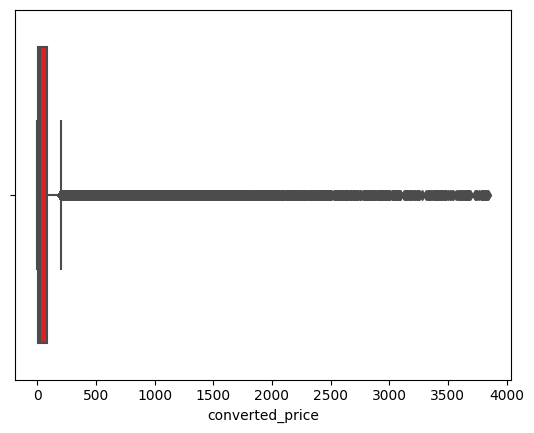

In [11]:
sns.boxplot(data = market_data_no_outliers, x='converted_price', color='red')
# plt.xlim(0,20000)
# plt.ylim(0,80)

The distribution of prices is highly right skewed.

### Win rate vs Price

<AxesSubplot: xlabel='win_rate', ylabel='converted_price'>

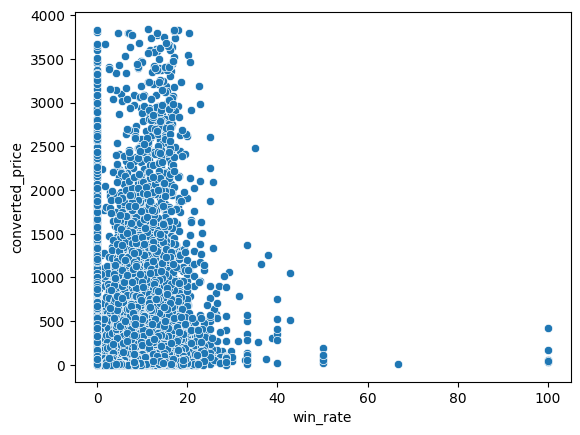

In [12]:
sns.scatterplot(data=market_data_no_outliers, x='win_rate', y='converted_price')

### Different Factors by Breed

In [13]:
by_breed = market_data_no_outliers.groupby('breed_type').mean().reset_index()
by_breed

/tmp/ipykernel_11813/4157081266.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_breed = market_data_no_outliers.groupby('breed_type').mean().reset_index()


,breed_type,time_sold,horse_id,super_coat,mother,father,free_win_rate,paid_win_rate,place,total_paid,win_rate,overall.first,overall.races,overall.second,overall.third,converted_price,z_score
0,cross,1.662909e+09,416312.150826,0.011761,284935.210108,294491.871742,4.051840,1.317069,13.267096,0.019149,3.882160,6.369358,78.414336,6.182613,6.128735,20.078084,0.125500
1,elite,1.661447e+09,387200.217384,0.011446,235481.718158,222533.164802,5.310729,2.335846,16.983039,0.052951,5.041171,11.561618,135.457229,11.496213,11.469707,31.889489,0.118139
2,exclusive,1.659331e+09,333602.526894,0.012631,159523.841556,92673.351518,5.522891,2.642925,17.519715,0.107187,5.223795,17.541137,197.405536,17.033363,16.871847,84.861508,0.121939
3,genesis,1.660587e+09,21897.416488,0.000000,0.000000,0.000000,7.331539,4.093276,22.603550,0.214875,6.491066,24.658432,287.448711,24.844522,24.576799,539.718844,0.338791
4,legendary,1.658651e+09,298319.725762,0.022790,14580.049315,12925.875873,5.648441,2.673956,17.831019,0.129056,5.256354,19.239539,219.513452,19.415634,19.274996,189.498113,0.160837
5,pacer,1.661643e+09,415614.001215,0.022968,259706.924535,313375.999635,2.012768,0.530695,7.750721,0.008032,1.954419,1.986876,44.361648,2.330174,2.573095,12.139662,0.128470


Text(0.5, 1.0, 'Mean Win Rate by Breed Type')

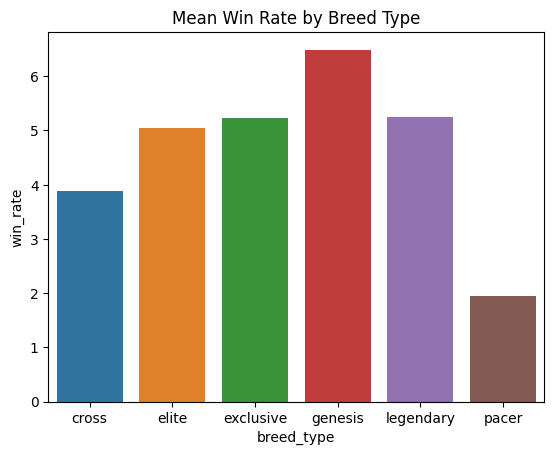

In [14]:
sns.barplot(data=by_breed, x='breed_type', y='win_rate')
plt.title('Mean Win Rate by Breed Type')

Text(0.5, 1.0, 'Mean Number of 1st Place Finishes by Breed')

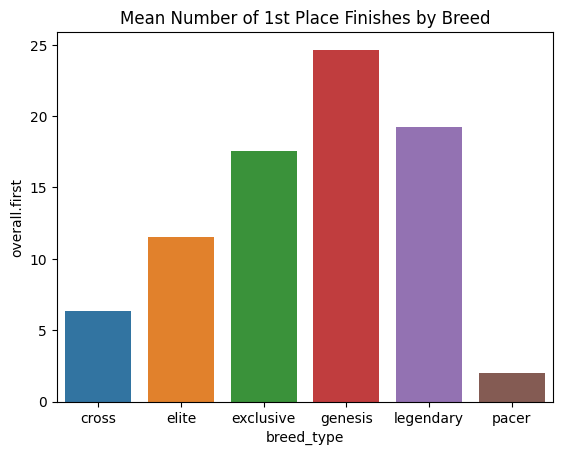

In [15]:
sns.barplot(data=by_breed, x='breed_type', y='overall.first')
plt.title('Mean Number of 1st Place Finishes by Breed')

<AxesSubplot: xlabel='breed_type', ylabel='converted_price'>

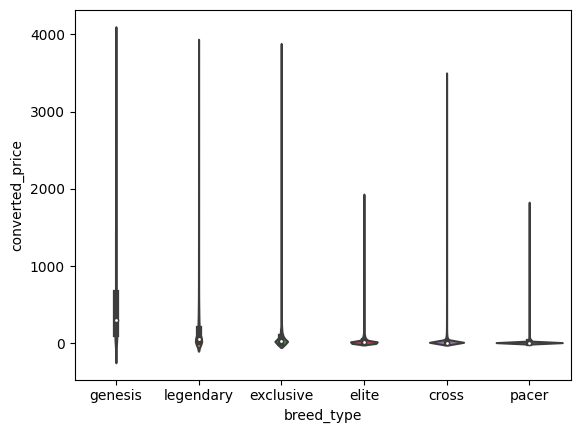

In [16]:
sns.violinplot(data=market_data_no_outliers, x='breed_type', y='converted_price')

### Different Factors by Bloodline

In [17]:
by_blood = market_data_no_outliers.groupby('bloodline').mean().reset_index()
by_blood

/tmp/ipykernel_11813/1683000179.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  by_blood = market_data_no_outliers.groupby('bloodline').mean().reset_index()


,bloodline,time_sold,horse_id,super_coat,mother,father,free_win_rate,paid_win_rate,place,total_paid,win_rate,overall.first,overall.races,overall.second,overall.third,converted_price,z_score
0,Buterin,1.660381e+09,323918.589748,0.019681,160738.338202,156802.056951,4.097103,1.779781,13.230708,0.048541,3.897295,10.549340,124.106768,9.769888,9.463360,47.731050,0.128033
1,Finney,1.659886e+09,328344.406089,0.013701,146239.287980,113273.595179,5.548128,2.650669,17.881493,0.092744,5.259366,16.455186,187.317412,15.954583,15.797336,88.408431,0.139458
2,Nakamoto,1.660043e+09,358206.659348,0.011355,136394.064617,108266.493915,6.138023,2.799857,19.427262,0.158203,5.644224,18.934881,219.500314,20.292723,20.577353,241.783989,0.172789
3,Szabo,1.659725e+09,334698.273201,0.010727,136212.888102,104283.003051,5.976671,2.852281,18.962947,0.119640,5.590634,18.759374,217.702884,19.074796,19.218482,149.367392,0.148824


(array([0, 1, 2, 3]),
 [Text(0, 0, 'Buterin'),
  Text(1, 0, 'Finney'),
  Text(2, 0, 'Nakamoto'),
  Text(3, 0, 'Szabo')])

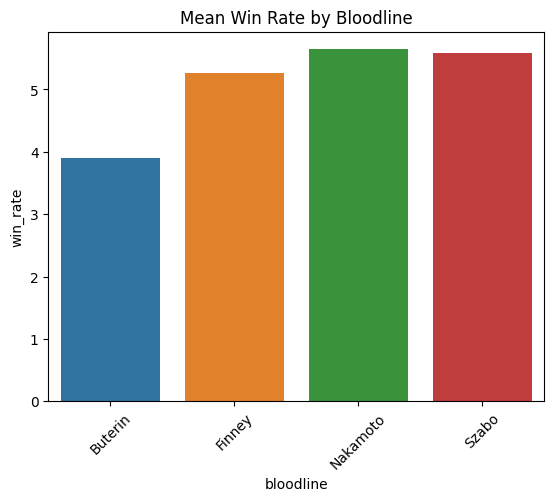

In [18]:
sns.barplot(data=by_blood, x='bloodline', y='win_rate')
plt.title('Mean Win Rate by Bloodline')
plt.xticks(rotation = 45)

(array([19052., 19083., 19113., 19144., 19174., 19205., 19236., 19266.,
        19297., 19327., 19358.]),
 [Text(19052.0, 0, '2022-03'),
  Text(19083.0, 0, '2022-04'),
  Text(19113.0, 0, '2022-05'),
  Text(19144.0, 0, '2022-06'),
  Text(19174.0, 0, '2022-07'),
  Text(19205.0, 0, '2022-08'),
  Text(19236.0, 0, '2022-09'),
  Text(19266.0, 0, '2022-10'),
  Text(19297.0, 0, '2022-11'),
  Text(19327.0, 0, '2022-12'),
  Text(19358.0, 0, '2023-01')])

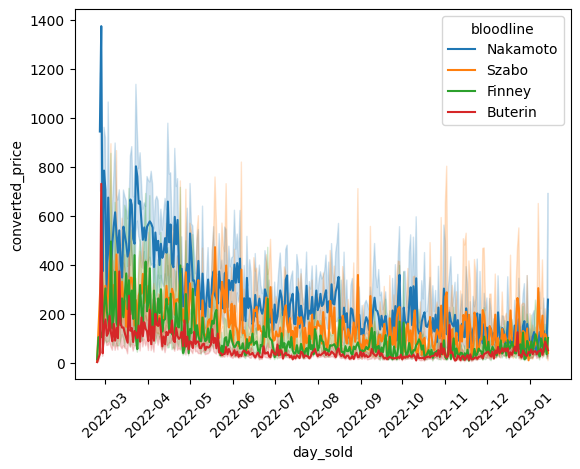

In [19]:
sns.lineplot(data=market_data_no_outliers, x='day_sold', y='converted_price', hue= 'bloodline')
plt.xticks(rotation=45)

## Model Fitting

### Adjust for categorical variables: One-hot encoding

In [20]:
# remove NaNs from the dataset
market_data_no_outliers = market_data_no_outliers[~pd.isna(market_data_no_outliers['converted_price'])]

In [21]:
# clean the dataset to only include desired predictors and separate out the X and y
# X will only have continuous variables for now
X = market_data_no_outliers.drop(columns=['converted_price', 'time_sold','horse_id','birthday', 'horse_id', 'mother', 'father', 'z_score', 'day_sold','bloodline', 'breed_type', 'color', 'genotype', 'horse_type', 'super_coat'])

y = market_data_no_outliers.converted_price
X.columns
y.shape

(74385,)

In [22]:
# # following accredited to ChatGPT
# from sklearn.preprocessing import OneHotEncoder

# # list of categorical variables:
# cat_vars = [ 'breed_type', 'bloodline',  'genotype', 'horse_type', 'super_coat']

# # one-hot encode all cat_vars
# encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# print(f'shape before one_hot: {X.shape}')
# for var in cat_vars:
#     # print(f'Overall df: {X.shape}')
#     # One-hot encode the categorical variable
#     categorical_variable_encoded = encoder.fit_transform(market_data_no_outliers[var].values.reshape(-1,1))

#     # Convert the encoded variable to a DataFrame
#     categorical_variable_encoded = pd.DataFrame(categorical_variable_encoded, columns=encoder.get_feature_names_out([var]))
#     # print(f'{var}:{categorical_variable_encoded.shape}')

#     # Concatenate the encoded variable with the original data
#     X = pd.concat([X, categorical_variable_encoded], axis=1)
# X.fillna(0, inplace=True)
# X = X[:74385]
# print(X.shape, y.shape)
# # X.tail(10)

### Select Model Hyperparameters

In [23]:
# following accredited to ChatGPT

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Define the model
model = LinearRegression()

# Define the parameter grid
param_grid = {'fit_intercept': [True, False], 'positive': [True, False]}

# Create the grid search object
grid = GridSearchCV(model, param_grid, cv=5, return_train_score=True)


# Fit the grid search to the data
grid.fit(X, y)

# Print the best parameters and score
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)
# print(f"{len(grid.feature_names_in_)} features selected out of {len(X.columns)}")
# print('Feature names:',grid.feature_names_in_)

Best parameters:  {'fit_intercept': True, 'positive': False}
Best score:  0.1395585180867172
Best estimator:  LinearRegression()


### Test out different feature selection methods

#### Split data into test and train sets

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=156,
                                   test_size=0.2,
                                   shuffle=True)

#### LassoCV
'This method works well with linear models and can be used to select both continuous and categorical predictors, it's particularly useful when there are a large number of predictors in the dataset and the goal is to select a subset of the most relevant features.' - ChatGPT

In [25]:
# fit model using LassoCV for feature selection
from sklearn.linear_model import LassoCV

# Create an instance of LassoCV
lasso = LassoCV(cv=5)

# Fit the LassoCV model to the data
lasso.fit(X_train, y_train)

# Get the selected features
# selected_features = X.columns[lasso.coef_ != 0]
selected_features = X.columns[lasso.coef_ != 0]
print(f'{len(selected_features)} features selected out of {len(X.columns)}: {", ".join(selected_features)}')

# get lasso score
score = lasso.score(X, y)
print(f'Model score is: {score}')

# Get a single data point from the DataFrame
data_point = X.iloc[5]
print(type(data_point))

# Make a prediction for the data point
prediction = lasso.predict(data_point.values.reshape(1, -1))
print(f"predition price in USD is: {prediction}")

7 features selected out of 9: free_win_rate, paid_win_rate, place, overall.first, overall.races, overall.second, overall.third
Model score is: 0.15816956382937053
<class 'pandas.core.series.Series'>
predition price in USD is: [351.86211398]


/home/a1/401/labs/mid_term/Thoroughzed/.venv/lib/python3.11/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(


In [26]:
from meta_data_query_and_loop_script import get_horse_data
# data_point = X.iloc[5]
# print(data_point.keys())
horse_id = 8919

if horse_id in clean_market_data['horse_id'].values:
    horse_to_predict = clean_market_data[clean_market_data['horse_id']== horse_id]
    print("was in database")
else:
    horse_to_predict = get_horse_data(horse_id)
categories = ['free_win_rate', 'paid_win_rate', 'place','total_paid', 'win_rate', 'overall.first', 'overall.races', 'overall.second', 'overall.third']

print(type(X.iloc[5]))
print(type(horse_to_predict))
horse_to_predict = horse_to_predict.filter(categories)
horse_to_predict = horse_to_predict.values.reshape(1,-1)
prediction_test = lasso.predict(horse_to_predict)
print(prediction_test)

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
[645.67853545]


/home/a1/401/labs/mid_term/Thoroughzed/.venv/lib/python3.11/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LassoCV was fitted with feature names
  warnings.warn(
